# Term Project - CS329E
#### University Of Texas at Austin
#### 30 November 2021 
###### Contributors: Keigan Kincaid  and Joshua Oh 

### Are young inexperienced pilots more likely to cause from fatal or severe injury in fixed wing general aviation aircraft incidents as opposed to there older more experienced counter parts?

#### What is our dataset about?

The NTSB aviation accident database contains information from 1962 and later about civil aviation accidents and selected incidents within the United States, its territories, and possessions, and in international waters. 

A preliminary report is available online within a few days of an accident. Information is added when available, and when the investigation is completed, the preliminary report is replaced with a final description of the accident and its probable cause. The dataset is updated monthly in Microsoft Access 2000 MDB format. 

For this project we decided to use a version of the dataset only including incidents from 2008 to the Present. Our decision for this was largely because the datasets before 2008 did not distinguish whether the event represented the pilot controlling the aircraft at the time or whether the event index was associate with co-pilots, crew, or passengers’ injuries or related statistics.

To appropriately address our research question and reduce our sample size from over 100,000 events to around 8000. The dataset was originally cleaned via Excel in the Microsoft Access 2000 MDB format. From there we selected the appropriate variables and compiled them into a single Excel file where we were able to remove repeats, and null values. Finally, we saved this subset of the original Microsoft Access Database in a CSV format.


#### Information Regarding Data Cleaning

As our dataset was around 8000 observations, we utilized a sample of 2000 observations. Then split this sample into an 80 / 20 split to test and train our classifiers.

#### Research question, What we hope to learn from data, and Learning model Implemented

Research Question: Are young inexperienced pilots more likely to cause from fatal or severe injury in fixed wing general aviation aircraft incidents as oppsed to there older more experienced counter parts?

In the study we hope to create a model that can classify injury level based upon pilot age, measured in years of age, and experienced, measured in hours actively piloting an aircraft.

It is important to note that flight hours are measured by the number of hours a plane has been operating an aircraft, which is kept in a log and verified in annual inspections by a third party in part to ensure the airworthiness of the vehicle, as well as its pilot. Further hours may be logged while completing training exercises as a co-pilot or with guided instruction for a CFI (Certified Flight Instructor.) 

Time logged in simulators or ground school are not included in pilot flight hours. In this study we are looking to use an industry standard classifier called an SVM to help predict pilot crash severity. The three classifiers we will be using are SVM using Sci-kit Learn, SVM SVC Linear Regression, and a Gradient Descent and Hinge Loss function without using libraries.

#### Expectations Regarding Results Prior to Study

Generally, we expect that younger pilots with less hours will be more reckless than those with more experience and more time in the cockpit. This inexperience is a key factor in why we believe these pilots will be responsible for a larger portion of fixed wing aviation incidents.

#### How we would like our project to be evaluated, How to assess correctness of our models, Thoughts on our models success prior to study

It is important to consider that we are only using two features to classify these events. That being Flight Hours and Age. There are many more features that play a part in aviation incidents which could be considered more direct correlations and indications of aviation incidents.

We expect the model to do better than random chance, that is 51% or better. I do not expect there to be a large difference in the implementations, however I do believe the data is not perfect so for future research it would be important to compare models that have the highest probability of predicting outcomes as well as including more features that will improve odds of correctness without blatantly representing outcomes such as engine failure, severe weather conditions, or drug / alcohol use.

#### Results

Our final results show that with the standard Sci-Kit Learn SVM we have an accurary > 50%, our Sci-Kit Learn Linear SVM has an accurary of >50%, and lastly our SVM with No Libraries struggles to reach a score over 10-15%.

#### What can you do to improve your results? What are limitations of your implementations or dataset?

I believe cleaning and analysising the data would improve the results. I believe their are outliners in the data that is preventing the SVM from performing better, further there are limited amount of features that we used which give the classifier little data points to make predictions from.

#### Ideas Applied to improve results:

One idea we used was adding an empty feature adding a column of ones. In the SVM typically more features will improve hte results. This had limited impact on the preformance.

#### Describe Code and Implementations:

We have taken the time to comment our code extensively so that you may understand in a human readable format what each component is doing and the concepts behind it.

#### References: 

NTSB Aviation Accident Database:
https://data.ntsb.gov/avdata

In [102]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.utils import shuffle

# Enable inline mode for matplotlib so that Jupyter displays graphs
%matplotlib inline

In [103]:
# loading in our crash data then shuffle the dataset so that it is difference each time we run the code
crash_df_raw = pd.read_csv('crash_Dataset.csv')

# Optional shuffle feature for testing
# crash_df_raw = shuffle(crash_df_raw)

In [104]:
# taking the first 2000 observations from the shuffled dataset
crash_df = crash_df_raw.head(n=2000)
crash_df

,ev_id,crew_age,crew_inj_level,flight_hours
0,20080514X00667,54,0,14500.0
1,20080312X00305,42,0,10000.0
2,20080827X01333,56,3,1200.0
3,20090526X53909,61,1,367.0
4,20090718X25941,65,0,1.0
...,...,...,...,...
1995,20140807X41115,44,0,1.0
1996,20140807X52333,59,0,10.0
1997,20140807X65826,47,1,0.0
1998,20140807X92309,70,2,9.0


In [105]:
# splitting into features and targets, X and Y respectively
X = crash_df[['crew_age', 'flight_hours']]
Y = crash_df['crew_inj_level']

# splitting the data into testing and training sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=512)

# re-indexing in dataframe
X_train = X_train.reset_index(drop=True)
Y_train = Y_train.reset_index(drop=True)

# printing shapes of Target training and test data
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(1500, 2)
(1500,)
(500, 2)
(500,)


## Logistic Regression

In [106]:
model = LogisticRegression(C=.01)
model.fit(X_train, Y_train)

y_pred = model.predict(X_test)

print("Accuracy Score:", accuracy_score(Y_test, y_pred), "\n")

print(classification_report(Y_test, y_pred))

Accuracy Score: 0.508 

              precision    recall  f1-score   support

           0       0.51      0.98      0.67       253
           1       0.00      0.00      0.00        53
           2       0.00      0.00      0.00        58
           3       0.44      0.05      0.09       136

    accuracy                           0.51       500
   macro avg       0.24      0.26      0.19       500
weighted avg       0.38      0.51      0.36       500



C:\Users\joshu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\joshu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\joshu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\sklearn\metrics\_classification.py:1308: Unde

## Implementation of SVM using Libraries

In [107]:
model = svm.SVC(C=.01)
model.fit(X_train, Y_train)

y_pred = model.predict(X_test)

In [108]:
print("Accuracy Score:", accuracy_score(Y_test, y_pred), "\n")

print(classification_report(Y_test, y_pred))

Accuracy Score: 0.506 

              precision    recall  f1-score   support

           0       0.51      1.00      0.67       253
           1       0.00      0.00      0.00        53
           2       0.00      0.00      0.00        58
           3       0.00      0.00      0.00       136

    accuracy                           0.51       500
   macro avg       0.13      0.25      0.17       500
weighted avg       0.26      0.51      0.34       500



C:\Users\joshu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\joshu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\joshu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\sklearn\metrics\_classification.py:1308: Unde

## Implementation of Linear SVC using Libraries

In [109]:
model = svm.LinearSVC(C=.01, max_iter=300, fit_intercept=False)
model.fit(X_train, Y_train)

y_pred = model.predict(X_test)

print("Accuracy Score:", accuracy_score(Y_test, y_pred))

# from sklearn.metrics import classification_report
print(classification_report(Y_test, y_pred))

Accuracy Score: 0.56
              precision    recall  f1-score   support

           0       0.61      0.81      0.69       253
           1       0.00      0.00      0.00        53
           2       0.00      0.00      0.00        58
           3       0.46      0.55      0.50       136

    accuracy                           0.56       500
   macro avg       0.27      0.34      0.30       500
weighted avg       0.43      0.56      0.49       500



C:\Users\joshu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\joshu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\joshu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` paramet

## Implementation of SVM without Libraries

### Function Predict SVM for Comparing Accuracy of Classifiers

In [110]:
def predict_svm(weights, X):
    """
    Predict the class between 0 and 1 using learned SVM parameters weights.
    """    
    return np.where(np.dot(X, weights)<0, -1, 1)

In [111]:
def compute_cost(X, y, W, regularization_factor):
    '''This function calculate the hinge loss. Primal Problem in SVM'''
    n = X.shape[0]
    distances = 1 - y * (np.dot(X, W))
    
    # This is our max(0, distance). 
    distances[distances < 0] = 0 
    
    hinge_loss = regularization_factor * (np.sum(distances) / n)
    # This divide by 2 is not important. You can skip doing it 
    # because we want only to check if this cost is going down or not. 
    return (1 / 2 * np.dot(W, W) + hinge_loss)

In [112]:
def calculate_gradient(X, y, W, regularization_factor):
      
    if type(y) == np.float64:
        y = np.array([y])
        X = np.array([X])
        
    distance = 1 - (y * np.dot(X, W))
    
    dw = np.zeros(len(W))
    
    for ind, d in enumerate(distance):
        
        if (d < 0):
            di = W
        else:
            di = W - (regularization_factor * y[ind] * X.loc[ind])
            
        dw += di
    
    dw = dw/len(y)  # average
    
    return dw

In [113]:
# adding column of ones for matrix multiplication (dot product)
x_0 = [1]*len(X_train)
X_train['x_0'] = x_0
X_train = X_train[['x_0', 'crew_age', 'flight_hours']]

x_01 = [1]*len(X_test)
X_test['x_0'] = x_01
X_test = X_test[['x_0', 'crew_age', 'flight_hours']]

In [114]:
# same length as previous matrices
# y intercept is the b, must have one additional and add to x column of 1s
# logistic reg and support vector having 1 additional 
# ex 16 or 16 1
weights = np.zeros(3)

# Now we optimize it using Gradient Descent. 
num_iterations = 20
learning_rate = 0.001
regularization = 0.01

cost_list = []

for i in range(0, num_iterations):
    
    # current iteration cost
    cost = compute_cost(X_train, Y_train, weights, regularization)
    
    print("Epoch", i, "Cost is:", cost, "\n", "Weights:\n", weights)
    print("Accuracy Score:", accuracy_score(Y_test, predict_svm(weights, X_test)), "\n")
    
    # appending current iteration cost
    cost_list.append(cost)
    
    # gradient descent (optimization)
    grad = calculate_gradient(X_train, Y_train, weights, regularization)
    
    # updating the weights
    weights = weights - learning_rate * grad

Epoch 0 Cost is: 0.01 
 Weights:
 [0. 0. 0.]
Accuracy Score: 0.106 

Epoch 1 Cost is: 0.007339454348542341 
 Weights:
 x_0             0.000011
crew_age        0.000606
flight_hours    0.038879
Name: 0, dtype: float64
Accuracy Score: 0.106 

Epoch 2 Cost is: 0.007290650076915729 
 Weights:
 x_0             0.000015
crew_age        0.000826
flight_hours    0.038852
Name: 0, dtype: float64
Accuracy Score: 0.106 

Epoch 3 Cost is: 0.007242622816192422 
 Weights:
 x_0             0.000019
crew_age        0.001044
flight_hours    0.038825
Name: 0, dtype: float64
Accuracy Score: 0.106 

Epoch 4 Cost is: 0.007195998921658793 
 Weights:
 x_0             0.000023
crew_age        0.001259
flight_hours    0.038798
Name: 0, dtype: float64
Accuracy Score: 0.106 

Epoch 5 Cost is: 0.007150433194750938 
 Weights:
 x_0             0.000027
crew_age        0.001470
flight_hours    0.038770
Name: 0, dtype: float64
Accuracy Score: 0.106 

Epoch 6 Cost is: 0.007104958553731171 
 Weights:
 x_0             

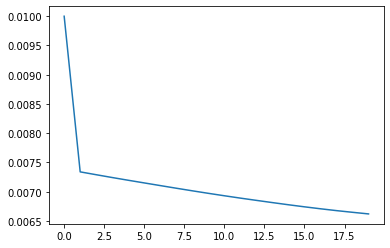

In [115]:
# plot cost per iteration
plt.plot(np.arange(num_iterations), cost_list)
plt.show()

In [116]:
print("Accuracy Score:", accuracy_score(Y_test, predict_svm(weights, X_test)) *100, '%')

print(classification_report(Y_test, predict_svm(weights, X_test)))

Accuracy Score: 10.6 %
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       253
           1       0.11      1.00      0.19        53
           2       0.00      0.00      0.00        58
           3       0.00      0.00      0.00       136

    accuracy                           0.11       500
   macro avg       0.03      0.25      0.05       500
weighted avg       0.01      0.11      0.02       500



C:\Users\joshu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\joshu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\joshu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\sklearn\metrics\_classification.py:1308: Unde